In [ ]:
%%bash
pip install uv
uv pip install --quiet --system torch torchvision transformers pillow opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 65.9 MB/s eta 0:00:00


In [ ]:
import torch
import cv2
import time
import os
import numpy as np

from transformers import BlipProcessor,BlipForConditionalGeneration

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

"cuda"

In [ ]:
processor = BlipProcessor.from_pretrained("salesforce/blip-image-captioning-base", use_fast = True)
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
model.to(device).eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

a group of cars racing down a race track


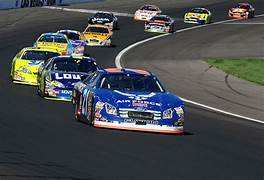

In [ ]:
from PIL import Image
import requests
from io import BytesIO

url = r'https://tse3.mm.bing.net/th/id/OIP.pTdZ3GAtIrBQZ8GRMMBWJgHaFC?pid=Api&P=0&h=180'

img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
with torch.no_grad():

       inputs = processor(img, return_tensors="pt").to(device)
       out = model.generate(**inputs, max_length=30, num_beams=5)

caption = processor.decode(out[0], skip_special_tokens=True)
print(caption)
img


In [ ]:
def generate(img, **k):
    with torch.no_grad():

       inputs = processor(img, return_tensors="pt").to(device)
       out = model.generate(**inputs, **k)

       caption = processor.decode(out[0], skip_special_tokens=True)
       return caption

variants = {
    "greedy": {"max_length": 30, "num_beams": 1},
    "beam=5": {"max_length": 30, "num_beams": 5},
    "top-k": {"max_length": 30, "num_beams": 5,"do_sample": True, "top_k": 50},
    "top-p": {"max_length": 30, "num_beams": 5,"do_sample": True, "top_p": 0.95},

}
for name, k in variants.items():
  print(name, generate(img,**k))



greedy a group of cars racing down a race track
beam=5 a group of cars racing down a race track
top-k a number of cars racing on a race track
top-p a group of cars racing on a race track


In [ ]:
from base64 import b64decode
import numpy as np
import cv2

def js_image(js_reply):

  #decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  #convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  #decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, 1)

  return img

In [ ]:
# Javascript to properly create our live vedio stream using our webcame as input
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def video_stream():
  js = Javascript('''
  var video;
  var div = null;
  var stream;
  var captureCanvas;
  var imgElements;
  var labelElement;

  var pendingResolve = null;
  var shutdown = false;

  function removeDom(){
    stream.getVideoTracks()[0].stop();
    video.remove();
    div.remove();
    video = null;
    div = null;
    stream = null;
    imgElement = null;
    captureCanvas = null;
    labelElement = null;
  }
  function onAnimationFrame(){
    if(!shutdown){
      window.requestAnimationFrame(onAnimationFrame);
    }
    if (pendingResolve){
      var result = "";
      if (!shutdown){
        captureCanvas.getContext('2d').drawImage(video,0,0,640,480);
        result = captureCanvas.toDataURL('image/jpeg',0.8)
      }
      var lp = pendingResolve;
      pendingResolve = null;
      lp(result);
      if (shutdown) { // Add this check to stop the animation loop
        removeDom();
      }
    }
  }

  async function createDom(){
    if (div != null){
      return stream;
    }
    div = document.createElement('div');
    div.style.border = '2px solid black';
    div.padding = '3px';
    div.style.width = "100%";
    div.style.maxWidth ="600%";
    document.body.appendChild(div);

    const modelOut = document.createElement('div');
    modelOut.innerHTML = "<span>Status:</span>";
    labelElement = document.createElement('span');
    labelElement.innerText = 'No data';
    labelElement.style.fontWeight = 'bold';
    modelOut.appendChild(labelElement);
    div.appendChild(modelOut);

    video = document.createElement('video');
    video.style.display = 'block';
    video.width = div.clientWidth - 6;
    video.setAttribute('playsinline', '');
    video.onclick = () => { shutdown = true; };
    stream = await navigator.mediaDevices.getUserMedia(
      {video: { facingMode: "environment"}});
    div.appendChild(video);

    imgElement = document.createElement('img');
    imgElement.style.position = 'absolute';
    imgElement.style.zIndex = 1;
    imgElement.onclick = () => {shutdown = true;};
    div.appendChild(imgElement);

    const instruction = document.createElement('div');
    instruction.innerHTML =
    '<span style="color: red; font-weight: bold">'+
    'When finished, click here or on the video to stop this demo</span>';
    div.appendChild(instruction);
    instruction.onclick = () => { shutdown = true;};

    video.srcObject = stream;
    await video.play();

    captureCanvas = document.createElement('canvas');
    captureCanvas.width = 640;
    captureCanvas.height = 480;
    window.requestAnimationFrame(onAnimationFrame);

    return stream;
      }

   async function stream_frame(label, imgData){
    if(shutdown){
      removeDom();
      shutdown = false;
      return '';
    }

    var preCreate = Date.now();
    stream = await createDom();

    var preShow = Date.now();
    if(label != ""){
      labelElement.innerHTML = label;
    }

    if(imgData != ""){
      var videoRect = video.getClientRects()[0];
      imgElement.style.top = videoRect.top + "px";
      imgElement.style.left = videoRect.left + "px";
      imgElement.style.width = videoRect.width + "px";
      imgElement.style.height = videoRect.height + "px";
      imgElement.src = imgData
    }
    var preCapture = Date.now();
    var result = await new Promise(function(resolve, reject){
      pendingResolve = resolve;
    }
    );
    shutdown = false;

    return {'creat': preShow - preCreate,
            'show': preCapture - preShow,
            'capture': Date.now() - preCapture,
            'img': result};
   }
   ''')

  display(js)

def video_frame(label, caption):
  data = eval_js('stream_frame("{}","{}")'.format(label, caption))
  return data

In [ ]:

def caption_frame(frame):
  pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  inputs = processor(images=pil_img, return_tensors='pt').to(device)
  with torch.no_grad():
       out = model.generate(**inputs, max_length=30, num_beams=5)

  return processor.decode(out[0], skip_special_tokens=True)

In [ ]:
import time
video_stream()
caption = ''
start = time.time()
frame = 0

while True:
  js_reply = video_frame("Capturing", caption)
  try:
    img = js_image(js_reply['img'])
  except TypeError:
    break
  captions  = caption_frame(img)
  frame += 1
  print(captions)

elapsed = time.time() - start
print(f"Average FPS: {frame/elapsed:.2f}")

<IPython.core.display.Javascript object>

a man sitting at a table in front of a laptop
a man in a plaid shirt standing in a room
a man standing in a room while talking on a cell phone
a man talking on a cell phone in a room
a man talking on a cell phone in a room
a man standing in front of a computer
a man standing in front of a computer
a man sitting at a desk with a laptop
a man sitting at a desk with a laptop
a man sitting at a desk with a laptop
a man wearing a plaid shirt
a man wearing a plaid shirt
a man wearing a plaid shirt
Average FPS: 0.77


In [ ]:


def caption_for_batch(frame):
  pil_imgs = [Image.fromarray(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)) for fr in frame]
  inputs = processor(images=pil_imgs, return_tensors='pt').to(device)
  with torch.no_grad():
       out = model.generate(**inputs, max_length=30, num_beams=5)

  return [processor.decode(o, skip_special_tokens=True) for o in out]

In [ ]:

video_stream()
caption = ''
start = time.time()
frame = 0

batch_size = 10
frame_buffer = []
captions = []
while True:
  js_reply = video_frame("Capturing", caption)
  try:
    img = js_image(js_reply['img'])
  except TypeError:
    break

  if len(frame_buffer) == batch_size:
     captions  = caption_for_batch(frame_buffer)
     print("\n".join(captions))
     frame_buffer = []
  else :
    frame_buffer.append(img)

  frame += 1


elapsed = time.time() - start
print(f"Average FPS: {frame/elapsed:.2f}")

<IPython.core.display.Javascript object>

Average FPS: 1.04


In [ ]:
!uv pip install --quiet openai




In [1]:
from openai import OpenAI
from google.colab import userdata

api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=api_key)

def refine_captions(captions):
    captions = "\n".join(captions)
    prompt = f"Combine the following captions from different frames of a video in a cohesive manner. Your output should serve as a caption of what’s happening in the video, do not make allusion to the frames. \n: {captions}"

    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )

    return resp.choices[0].message.content

refine_captions(captions)


NameError: name 'captions' is not defined

In [ ]:

video_stream()
caption = ''
start = time.time()
frame = 0

batch_size = 120
frame_buffer = []
captions = []
while True:
  js_reply = video_frame("Capturing", caption)
  try:
    img = js_image(js_reply['img'])
  except TypeError:
    break

  print(len(frame_buffer))
  if len(frame_buffer) == batch_size:
     captions  = caption_for_batch(frame_buffer)
     print(refine_captions(captions))
     frame_buffer = []
  else :
    frame_buffer.append(img)

  frame += 1


elapsed = time.time() - start
print(f"Average FPS: {frame/elapsed:.2f}")